In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import attila_utils

In [2]:
treatments = {
    'A': 'Amiloride',
    'B': 'HCQ',
    'C': 'HCQ nano',
    'D': 'Saline',
    'E': 'R-HCQ',
    'F': 'S-HCQ',
    'G': 'TUDCA',
    'H': 'Saline WT',
    'I': 'TUDCA WT',
    'J': 'DMSO WT',
}

In [3]:
fpath = '../../resources/QPS/5xFAD-mouse/CO28152_NFL-GFAP_datasum.xlsx'
nfl_invivo = pd.read_excel(fpath, sheet_name='NFL in vivo clean')
nfl_invivo = nfl_invivo.melt(id_vars=['Cohort', 'Group', 'IRN', 'Sex', 'Genotype'], value_name='NF-L')
nfl_invivo['Week'] = nfl_invivo.variable.str.replace('NF-L week ', '').astype(int)
nfl_invivo['IRN'] = nfl_invivo.IRN.astype('str')
nfl_invivo['Sex'] = pd.Categorical(nfl_invivo['Sex'], categories=['m', 'f'], ordered=True)
nfl_invivo

,Cohort,Group,IRN,Sex,Genotype,variable,NF-L,Week
0,I,A,15117,f,tg/wt,NF-L week 0,576.0,0
1,I,A,15119,f,tg/wt,NF-L week 0,698.0,0
2,I,A,14627 A,f,tg/wt,NF-L week 0,701.0,0
3,III,A,15161,f,tg/wt,NF-L week 0,574.0,0
4,II,A,15938,m,tg/wt,NF-L week 0,291.0,0
...,...,...,...,...,...,...,...,...
231,V,J,15195 A,f,wt/wt,NF-L week 12,42.0,12
232,VI,J,15251,f,wt/wt,NF-L week 12,35.0,12
233,V,J,16180,m,wt/wt,NF-L week 12,24.0,12
234,V,J,16192,m,wt/wt,NF-L week 12,44.0,12


/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                   MixedLM       Dependent Variable:       Q("NF-L") 
No. Observations:        48            Method:                   REML      
No. Groups:              12            Scale:                    17187.7269
Min. group size:         4             Log-Likelihood:           -281.7800 
Max. group size:         4             Converged:                Yes       
Mean group size:         4.0                                               
---------------------------------------------------------------------------
                             Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------
Intercept                     87.125   58.775  1.482 0.138  -28.071 202.321
Sex[T.f]                      -1.083   74.965 -0.014 0.988 -148.013 145.846
Treatment[T.5xFAD]           512.667   74.965  6.839 0.000  365.737 659.596
Sex[T.f]:Treatment[T.5xFAD]  -25.500  106.017 -0.241 0.810 -233.290 182.290
Week                           0.354    4.231  0.084 0.933   -7.939   8.647
IRN Var                     4132.780   35.635                              
===========================================================================

"""

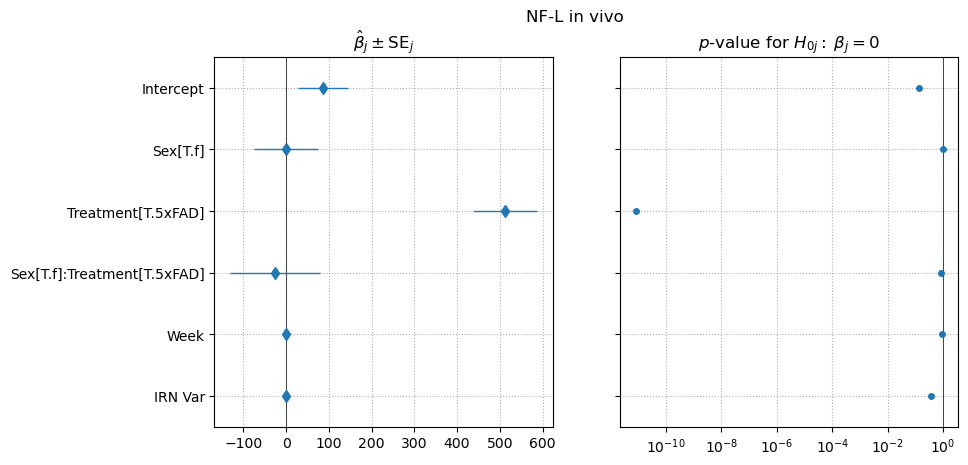

In [4]:
def fitter(formula, group_list, treatments=treatments, df=nfl_invivo, return_data=False, mixed=True):
    data = df.loc[df.Group.isin(group_list)].copy()
    treatment_list = [treatments[g] for g in group_list]
    s = data.Group.apply(lambda g: treatments[g])
    data['Treatment'] = pd.Categorical(s, categories=treatment_list, ordered=True)
    data = data.dropna()
    if return_data:
        return(data)
    if mixed:
        result = smf.mixedlm(formula, data=data, groups='IRN').fit()
    else:
        result = smf.ols(formula, data=data).fit()
    return(result)

def results_plotter(results, suptitle='', drop_intercept=True):
    df = pd.concat([results.params.to_frame('mean'),
                    results.bse.to_frame('bse'),
                    results.pvalues.to_frame('pval')], axis=1)
    df['treatment'] = df.index
    df = df.drop('Intercept') if drop_intercept else df
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9.6, 4.8))
    ax[0].axvline(0, color='k', linewidth=0.5)
    ax[0].grid(linestyle='dotted')
    ax[0].errorbar(y=np.arange(df.shape[0]), x=df['mean'], xerr=df['bse'], linewidth=0, elinewidth=1, marker='d', capsize=0)
    ax[0].set_title(r'$\hat{\beta}_j \pm \mathrm{SE}_j$')
    ax[1].axvline(1, color='k', linewidth=0.5)
    sns.stripplot(x='pval', y='treatment', ax=ax[1], data=df)
    ax[1].grid(linestyle='dotted')
    ax[1].set_xscale('log')
    ax[1].set_xlabel('')
    ax[1].set_title(r'$p$-value for $H_{0j}: \; \beta_j = 0$')
    fig.suptitle(suptitle)
    return((fig, ax))

formula = 'Q("NF-L") ~ 1 + Sex * Treatment + Week'
results = fitter(formula, group_list=['H', 'D'], treatments={'D': '5xFAD', 'H': 'WT'}, df=nfl_invivo)
fig, ax = results_plotter(results, 'NF-L in vivo', drop_intercept=False)
attila_utils.savefig(fig, 'NF-L-in-vivo-wt-tg')
results.summary()

## Drug treatments in 5xFAD background

/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                   MixedLM       Dependent Variable:       Q("NF-L") 
No. Observations:        166           Method:                   REML      
No. Groups:              42            Scale:                    16448.3097
Min. group size:         2             Log-Likelihood:           -1005.5260
Max. group size:         4             Converged:                Yes       
Mean group size:         4.0                                               
---------------------------------------------------------------------------
                             Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------
Intercept                    562.750   57.742  9.746 0.000  449.577 675.923
Treatment[T.Amiloride]        82.133   81.660  1.006 0.315  -77.917 242.184
Treatment[T.HCQ]             -45.150   81.660 -0.553 0.580 -205.201 114.901
Treatment[T.HCQ nano]         74.100   81.660  0.907 0.364  -85.951 234.151
Treatment[T.R-HCQ]            -1.833   81.660 -0.022 0.982 -161.884 158.217
Treatment[T.S-HCQ]          -109.001   81.818 -1.332 0.183 -269.361  51.359
Treatment[T.TUDCA]           -74.450   81.660 -0.912 0.362 -234.501  85.601
Week                           4.312    5.854  0.737 0.461   -7.161  15.786
Treatment[T.Amiloride]:Week    0.429    8.279  0.052 0.959  -15.797  16.655
Treatment[T.HCQ]:Week         -3.683    8.279 -0.445 0.656  -19.909  12.542
Treatment[T.HCQ nano]:Week    -7.225    8.279 -0.873 0.383  -23.451   9.001
Treatment[T.R-HCQ]:Week        1.896    8.279  0.229 0.819  -14.330  18.122
Treatment[T.S-HCQ]:Week       -5.792    8.561 -0.677 0.499  -22.571  10.986
Treatment[T.TUDCA]:Week       -0.675    8.279 -0.082 0.935  -16.901  15.551
IRN Var                     8491.285   26.778                              
===========================================================================

"""

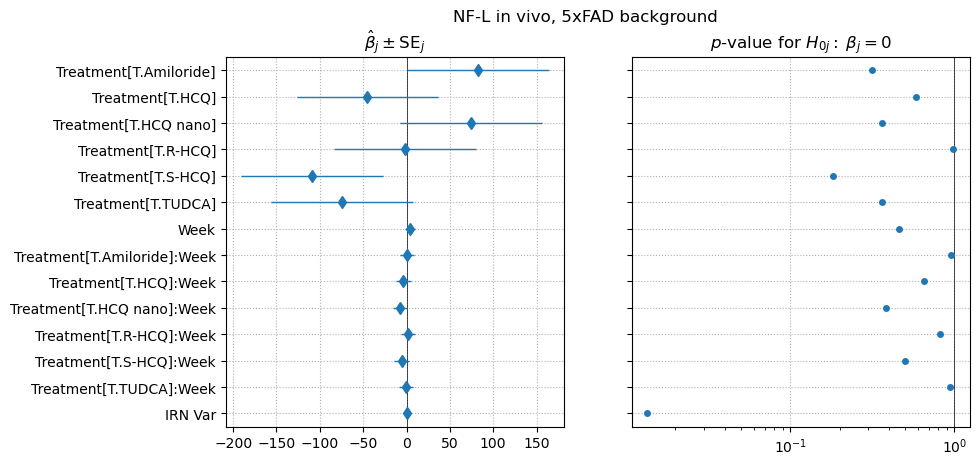

In [5]:
formula = 'Q("NF-L") ~ 1 + Sex + Treatment * Week'
group_list = ['D', 'A', 'B', 'C', 'E', 'F', 'G']
formula = 'Q("NF-L") ~ 1 + Treatment * Week'
results = fitter(formula, group_list, treatments=treatments)
fig, ax = results_plotter(results, 'NF-L in vivo, 5xFAD background')
attila_utils.savefig(fig, 'NF-L-in-vivo-treatments-tg')
results.summary()

### S-HCQ as the only treatment

/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM      Dependent Variable:      Q("NF-L") 
No. Observations:      46           Method:                  REML      
No. Groups:            12           Scale:                   15666.7690
Min. group size:       2            Log-Likelihood:          -275.0938 
Max. group size:       4            Converged:               Yes       
Mean group size:       3.8                                             
-----------------------------------------------------------------------
                         Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------
Intercept                562.750   49.987 11.258 0.000  464.778 660.722
Treatment[T.S-HCQ]      -108.830   70.862 -1.536 0.125 -247.717  30.058
Week                       4.312    5.713  0.755 0.450   -6.885  15.510
Treatment[T.S-HCQ]:Week   -5.950    8.331 -0.714 0.475  -22.279  10.378
IRN Var                 4025.345   32.618                              
=======================================================================

"""

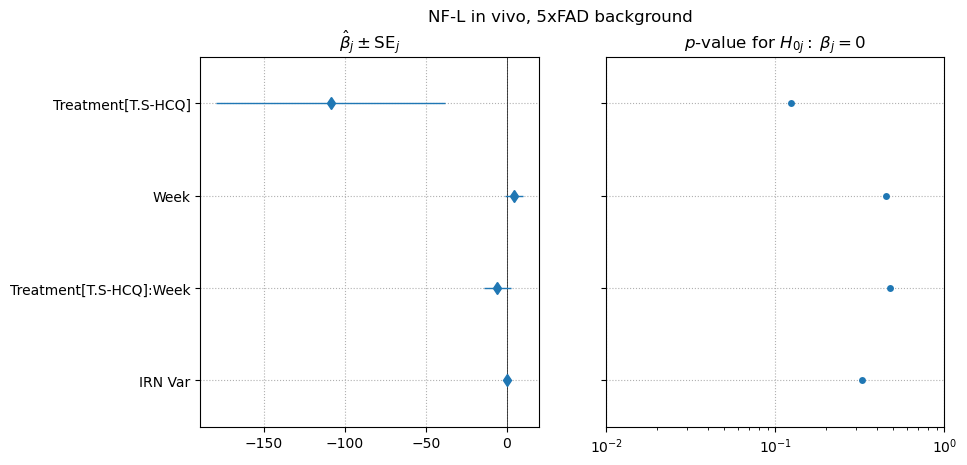

In [6]:
formula = 'Q("NF-L") ~ 1 + Sex + Treatment * Week'
group_list = ['D', 'F']
formula = 'Q("NF-L") ~ 1 + Treatment * Week'
results = fitter(formula, group_list, treatments=treatments)
fig, ax = results_plotter(results, 'NF-L in vivo, 5xFAD background')
ax[1].set_xlim([1e-2, 1])
attila_utils.savefig(fig, 'NF-L-in-vivo-S-HCQ-tg')
results.summary()

### S-HCQ as the only treatment: fixed effects model

/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q("NF-L")   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     4.360
Date:                Thu, 21 Dec 2023   Prob (F-statistic):            0.00923
Time:                        15:00:34   Log-Likelihood:                -290.21
No. Observations:                  46   AIC:                             588.4
Df Residuals:                      42   BIC:                             595.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 562.7500     47.528     11.840      0.000     466.834     658.666
Treatment[T.S-HCQ]       -108.4821     67.427     -1.609      0.115    -244.555      27.590
Week                        4.3125      6.351      0.679      0.501      -8.505      17.130
Treatment[T.S-HCQ]:Week    -6.2713      9.200     -0.682      0.499     -24.837      12.295
==============================================================================
Omnibus:                        0.956   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.620   Jarque-Bera (JB):                0.353
Skew:                           0.166   Prob(JB):                        0.838
Kurtosis:                       3.272   Cond. No.                         31.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

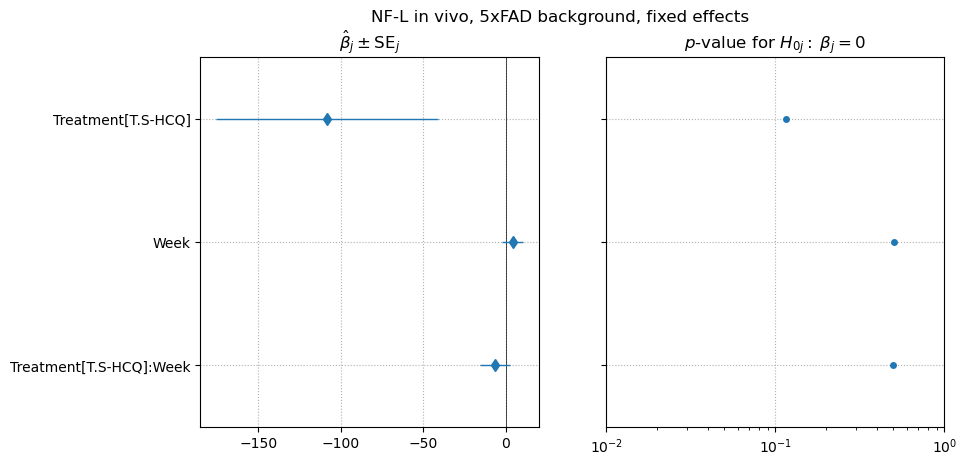

In [7]:
formula = 'Q("NF-L") ~ 1 + Sex + Treatment * Week'
group_list = ['D', 'F']
formula = 'Q("NF-L") ~ 1 + Treatment * Week'
results = fitter(formula, group_list, treatments=treatments, mixed=False)
fig, ax = results_plotter(results, 'NF-L in vivo, 5xFAD background, fixed effects')
ax[1].set_xlim([1e-2, 1])
attila_utils.savefig(fig, 'NF-L-in-vivo-S-HCQ-tg-fixed')
results.summary()

## Drug treatments in WT background

/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       Q("NF-L")
No. Observations:       66            Method:                   REML     
No. Groups:             17            Scale:                    4723.3806
Min. group size:        3             Log-Likelihood:           -352.6998
Max. group size:        4             Converged:                Yes      
Mean group size:        3.9                                              
-------------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------
Intercept                  110.333   23.475  4.700 0.000   64.324 156.343
Treatment[T.TUDCA WT]      -31.996   34.690 -0.922 0.356  -99.987  35.996
Treatment[T.DMSO WT]       -54.213   34.819 -1.557 0.119 -122.457  14.030
Week                        -3.604    3.137 -1.149 0.251   -9.752   2.544
Treatment[T.TUDCA WT]:Week   1.701    4.544  0.374 0.708   -7.205  10.607
Treatment[T.DMSO WT]:Week    3.784    4.653  0.813 0.416   -5.335  12.904
IRN Var                      0.000    9.608                              
=========================================================================

"""

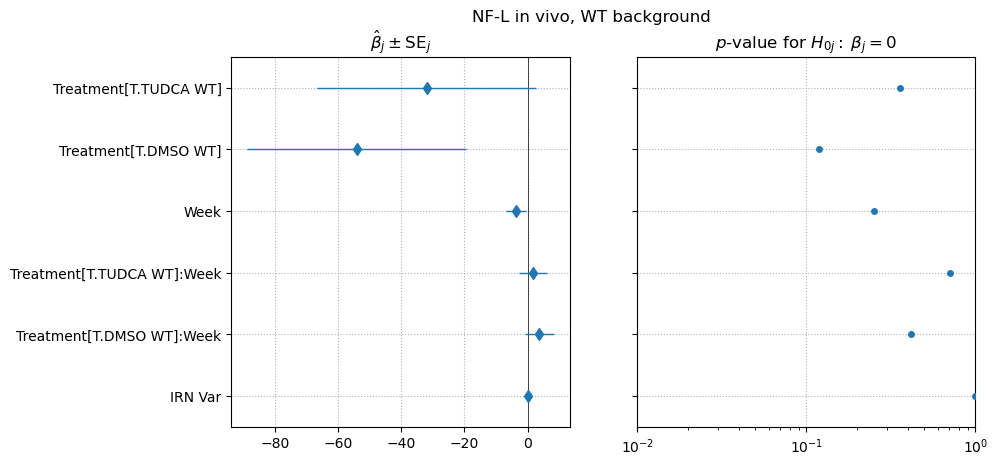

In [8]:
formula = 'Q("NF-L") ~ 1 + Sex + Treatment * Week'
group_list = ['H', 'I', 'J']
formula = 'Q("NF-L") ~ 1 + Treatment * Week'
results = fitter(formula, group_list, treatments=treatments)
fig, ax = results_plotter(results, 'NF-L in vivo, WT background')
ax[1].set_xlim([1e-2, 1])
attila_utils.savefig(fig, 'NF-L-in-vivo-treatments-wt')
results.summary()

## Terminal plasma and CSF

In [9]:
fpath = '../../resources/QPS/5xFAD-mouse/CO28152_NFL-GFAP_datasum.xlsx'
nfl_term = pd.read_excel(fpath, sheet_name='NFL terminal clean')
nfl_term['IRN'] = nfl_term.IRN.astype('str')
s = nfl_term.iloc[:, -2:].mean()
do_scale_NFL_CSF = False
scaler = s.loc['NF-L terminal plasma'] / s.loc['NF-L terminal CSF'] if do_scale_NFL_CSF else 1
nfl_term['NF-L terminal CSF'] = nfl_term['NF-L terminal CSF'] * scaler
nfl_term_scaled = nfl_term.melt(id_vars=['Cohort', 'Group', 'IRN', 'Sex', 'Genotype'], value_name='NF-L', var_name='Location')
nfl_term_scaled['x'] = nfl_term_scaled.Location.apply(lambda x: {'NF-L terminal plasma': 0, 'NF-L terminal CSF': 1}[x])
nfl_term_scaled

,Cohort,Group,IRN,Sex,Genotype,Location,NF-L,x
0,I,A,15117,f,tg/wt,NF-L terminal plasma,1679.0,0
1,I,A,15119,f,tg/wt,NF-L terminal plasma,828.0,0
2,I,A,14627 A,f,tg/wt,NF-L terminal plasma,1102.0,0
3,III,A,15161,f,tg/wt,NF-L terminal plasma,657.0,0
4,II,A,15938,m,tg/wt,NF-L terminal plasma,482.0,0
...,...,...,...,...,...,...,...,...
113,V,J,15195 A,f,wt/wt,NF-L terminal CSF,586.0,1
114,VI,J,15251,f,wt/wt,NF-L terminal CSF,594.0,1
115,V,J,16180,m,wt/wt,NF-L terminal CSF,514.0,1
116,V,J,16192,m,wt/wt,NF-L terminal CSF,275.0,1


In [10]:
nfl = pd.concat([nfl_invivo.rename({'variable': 'Location'}, axis=1), nfl_term_scaled], axis=0).drop(['Week', 'x'], axis=1)
nfl['Sex'] = pd.Categorical(nfl.Sex, categories=['m', 'f'], ordered=True)

['named-figure/nfl-week-12-vs-terminal-plasma-tg.png',
 'named-figure/nfl-week-12-vs-terminal-plasma-tg.pdf']

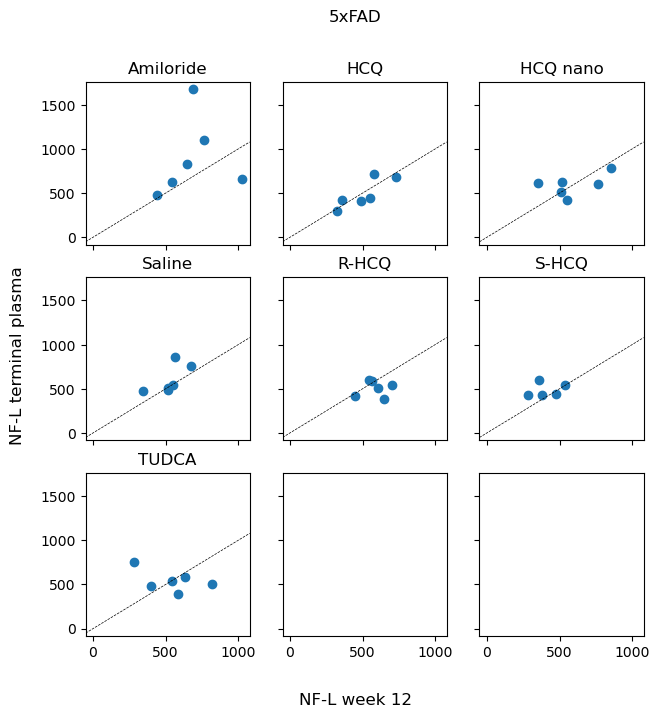

In [11]:
def nfl_corrplot(genotype='tg/wt', x='NF-L week 12', y='NF-L terminal plasma', nfl=nfl):
    nfl_genotype = nfl.loc[(nfl.Genotype == genotype)]
    nrows = int(np.ceil(np.sqrt(len(nfl_genotype.Group.unique()))))
    n = int(np.ceil(len(nfl_genotype.Group.unique()) / nrows))
    panelsize = 2.4
    fig, ax = plt.subplots(n, nrows, sharex=True, sharey=True, figsize=(nrows * panelsize, nrows * panelsize))
    for g, axi in zip(nfl_genotype.Group.unique(), np.ravel(ax)):
        axi.axline((0, 0), slope=1, color='k', linestyle='dashed', linewidth=0.5)
        sel_rows = (nfl_genotype.Group == g) & (nfl_genotype.Location.isin([x, y]))
        df = nfl_genotype.loc[sel_rows, ['IRN', 'Location', 'NF-L']]
        axi.scatter(x=x, y=y, data=df.pivot(index='IRN', columns='Location', values='NF-L'))
        axi.set_title(treatments[g])

    fig.supxlabel(x)
    fig.supylabel(y)
    fig.suptitle({'tg/wt': '5xFAD', 'wt/wt': 'WT'}[genotype])
    return((fig, ax))

fig, ax = nfl_corrplot(genotype='tg/wt', x='NF-L week 12', y='NF-L terminal plasma', nfl=nfl)
attila_utils.savefig(fig, 'nfl-week-12-vs-terminal-plasma-tg')

['named-figure/nfl-week-12-vs-terminal-plasma-wt.png',
 'named-figure/nfl-week-12-vs-terminal-plasma-wt.pdf']

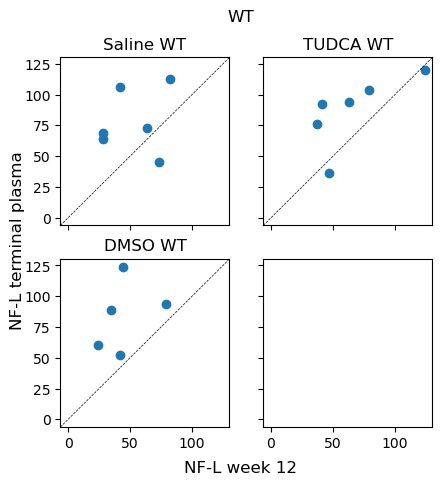

In [12]:
fig, ax = nfl_corrplot(genotype='wt/wt', x='NF-L week 12', y='NF-L terminal plasma', nfl=nfl)
attila_utils.savefig(fig, 'nfl-week-12-vs-terminal-plasma-wt')

['named-figure/nfl-terminal-CSF-vs-terminal-plasma-tg.png',
 'named-figure/nfl-terminal-CSF-vs-terminal-plasma-tg.pdf']

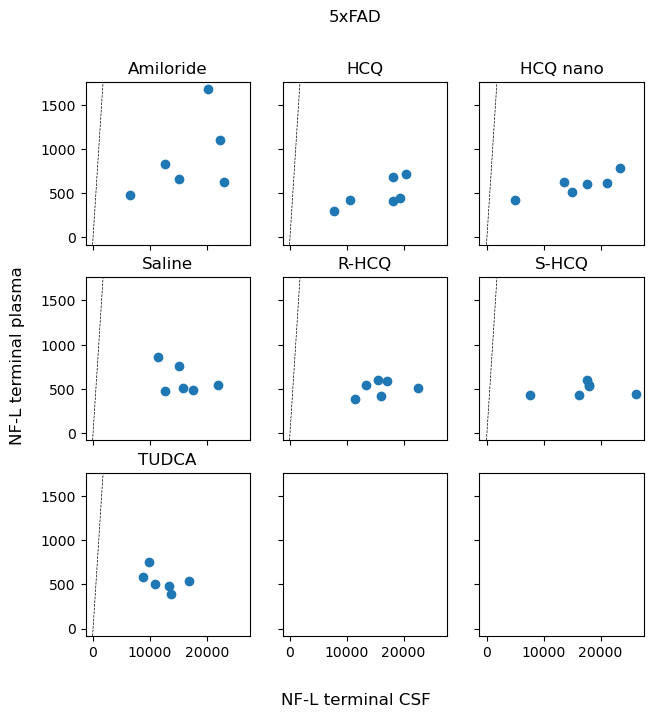

In [13]:
fig, ax = nfl_corrplot(genotype='tg/wt', x='NF-L terminal CSF', y='NF-L terminal plasma', nfl=nfl)
attila_utils.savefig(fig, 'nfl-terminal-CSF-vs-terminal-plasma-tg')

['named-figure/nfl-terminal-CSF-vs-terminal-plasma-wt.png',
 'named-figure/nfl-terminal-CSF-vs-terminal-plasma-wt.pdf']

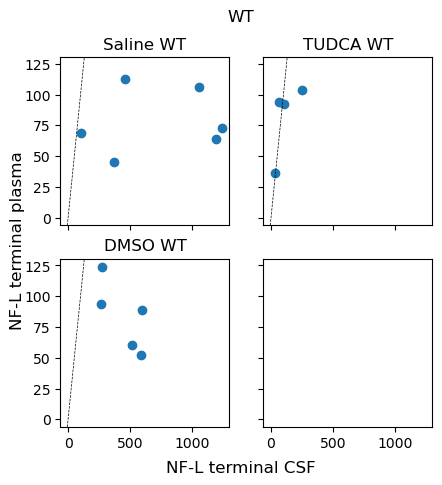

In [14]:
fig, ax = nfl_corrplot(genotype='wt/wt', x='NF-L terminal CSF', y='NF-L terminal plasma', nfl=nfl)
attila_utils.savefig(fig, 'nfl-terminal-CSF-vs-terminal-plasma-wt')

/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                  MixedLM     Dependent Variable:     Q("NF-L") 
No. Observations:       83          Method:                 REML      
No. Groups:             42          Scale:                  25681.7026
Min. group size:        1           Log-Likelihood:         -500.3893 
Max. group size:        2           Converged:              Yes       
Mean group size:        2.0                                           
----------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------
Intercept               494.051   55.379  8.921 0.000  385.511 602.592
Sex[T.f]                145.064   43.909  3.304 0.001   59.004 231.123
Treatment[T.Amiloride]  199.323   72.272  2.758 0.006   57.673 340.973
Treatment[T.HCQ]        -67.417   71.900 -0.938 0.348 -208.339  73.505
Treatment[T.HCQ nano]    26.167   71.900  0.364 0.716 -114.755 167.089
Treatment[T.R-HCQ]      -69.355   73.375 -0.945 0.345 -213.167  74.458
Treatment[T.S-HCQ]     -104.771   73.375 -1.428 0.153 -248.584  39.042
Treatment[T.TUDCA]       50.199   75.177  0.668 0.504  -97.147 197.544
IRN Var                2668.130   31.577                              
======================================================================

"""

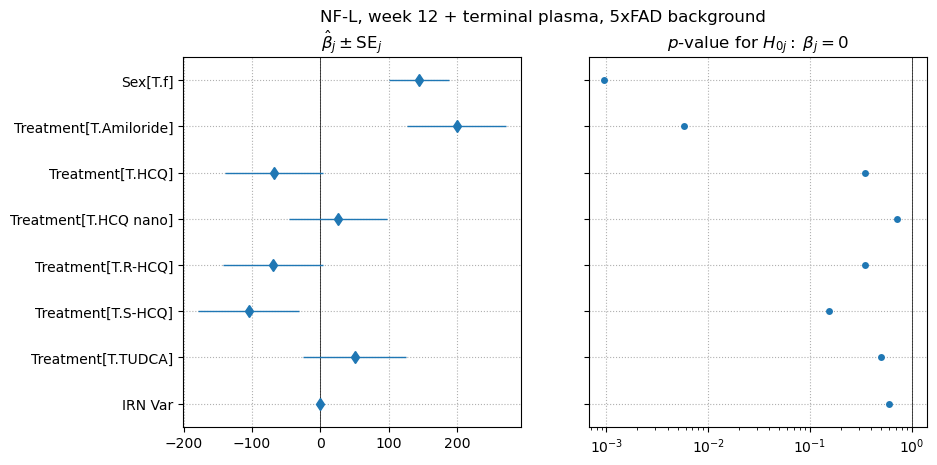

In [15]:
formula = 'Q("NF-L") ~ 1 + Sex + Treatment'
group_list = ['D', 'A', 'B', 'C', 'E', 'F', 'G']
df = nfl.loc[(nfl.Genotype == 'tg/wt') & (nfl.Location.isin(['NF-L week 12', 'NF-L terminal plasma']))]
results = fitter(formula, group_list=group_list, treatments=treatments, df=df)
fig, ax = results_plotter(results, 'NF-L, week 12 + terminal plasma, 5xFAD background')
attila_utils.savefig(fig, 'NF-L-week12-terminal-plasma-treatments-tg')
results.summary()

/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:                 MixedLM    Dependent Variable:    Q("NF-L")
No. Observations:      23         Method:                REML     
No. Groups:            12         Scale:                 8889.9759
Min. group size:       1          Log-Likelihood:        -126.4659
Max. group size:       2          Converged:             Yes      
Mean group size:       1.9                                        
------------------------------------------------------------------
                    Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------
Intercept           544.771   52.171 10.442 0.000  442.517 647.025
Sex[T.f]             43.624   60.769  0.718 0.473  -75.480 162.729
Treatment[T.S-HCQ] -107.542   60.769 -1.770 0.077 -226.647  11.562
IRN Var            6346.850   72.110                              
==================================================================

"""

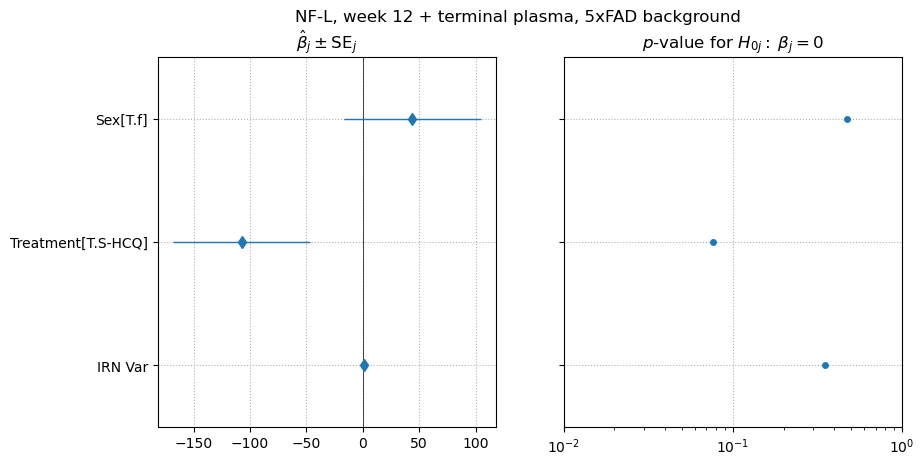

In [16]:
formula = 'Q("NF-L") ~ 1 + Sex + Treatment'
group_list = ['D', 'F']
df = nfl.loc[(nfl.Genotype == 'tg/wt') & (nfl.Location.isin(['NF-L week 12', 'NF-L terminal plasma']))]
results = fitter(formula, group_list=group_list, treatments=treatments, df=df)
fig, ax = results_plotter(results, 'NF-L, week 12 + terminal plasma, 5xFAD background')
ax[1].set_xlim([1e-2, 1])
attila_utils.savefig(fig, 'NF-L-week12-terminal-plasma-S-HCQ-wt')
results.summary()

/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:                 MixedLM    Dependent Variable:    Q("NF-L")
No. Observations:      34         Method:                REML     
No. Groups:            17         Scale:                 755.3237 
Min. group size:       2          Log-Likelihood:        -149.0195
Max. group size:       2          Converged:             Yes      
Mean group size:       2.0                                        
------------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------
Intercept              70.278   12.053  5.831 0.000  46.654 93.902
Sex[T.f]               -9.389   14.406 -0.652 0.515 -37.625 18.847
Treatment[T.TUDCA WT]   5.806   15.449  0.376 0.707 -24.474 36.085
Treatment[T.DMSO WT]   -2.222   14.406 -0.154 0.877 -30.458 26.014
IRN Var               182.700   10.624                            
==================================================================

"""

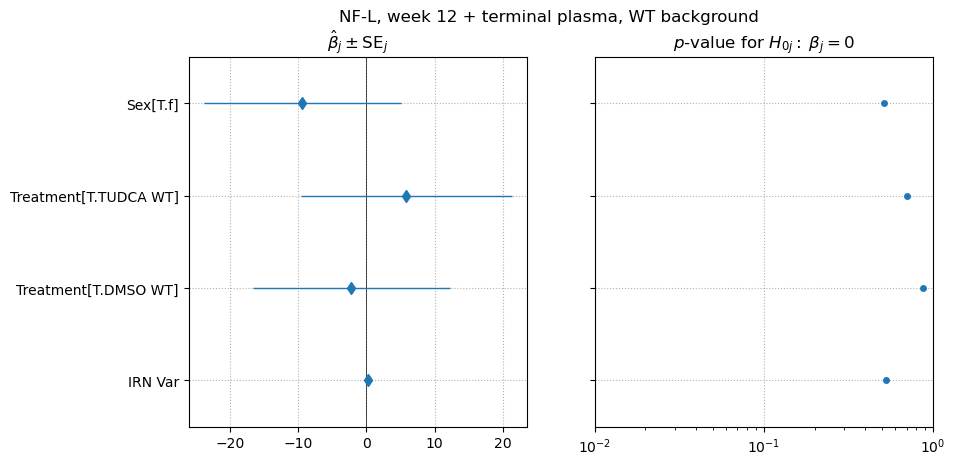

In [17]:
formula = 'Q("NF-L") ~ 1 + Sex + Treatment'
group_list = ['H', 'I', 'J']
df = nfl.loc[(nfl.Genotype == 'wt/wt') & (nfl.Location.isin(['NF-L week 12', 'NF-L terminal plasma']))]
results = fitter(formula, group_list=group_list, treatments=treatments, df=df)
fig, ax = results_plotter(results, 'NF-L, week 12 + terminal plasma, WT background')
ax[1].set_xlim([1e-2, 1])
attila_utils.savefig(fig, 'NF-L-week12-terminal-plasma-treatments-wt')
results.summary()

In [18]:
%connect_info

{
  "shell_port": 55488,
  "iopub_port": 55489,
  "stdin_port": 55490,
  "control_port": 55492,
  "hb_port": 55491,
  "ip": "127.0.0.1",
  "key": "42855036-ec0d016578fff06abf871689",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-50bd1191-449a-4fea-a19f-c636a2cbc127.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
